In [55]:
import os
import constants as c
import yaml
import numpy as np
import tensorflow as tf
import datetime
import boto3
import matplotlib.pyplot as plt

import tensorflow.keras as keras
import s3fs
import h3
import geopandas as gpd

from tqdm import tqdm
from collections import deque
from shapely.geometry import Point
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input
from models import ResnetTripletEmbedding, triplet_loss
from umap import UMAP
from landcover import LandCoverPatches
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct
from qdrant_client.http import models
from shapely.geometry import Polygon
from h3_utils import h3_global_iterator

secrets = yaml.load(open(os.path.join(c.BASE_DIR, 'secrets.yml')), Loader=yaml.FullLoader)

s3 = boto3.client(
    's3',
    aws_access_key_id=secrets['aws_access_key_id'],
    aws_secret_access_key=secrets['aws_secret_access_key']
)

fs = s3fs.S3FileSystem(
    key=secrets['aws_access_key_id'],
    secret=secrets['aws_secret_access_key']
)

qdrant_client = QdrantClient(
    url=secrets['qdrant_url'], 
    api_key=secrets['qdrant_api_key']
)

qdrant_client.recreate_collection(
    collection_name="vectorgeo",
    vectors_config=VectorParams(size=8, distance=Distance.COSINE),
)

True

### Script parameters

In [ ]:
inference_batch_size = 32
h3_resolution        = 7
seed_lat, seed_lng   = 47.475099, -122.170557
image_size           = 32
model_filename = "resnet-triplet-lc.keras"
lc_path = os.path.join(c.DATA_DIR, 'PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif')

### Retrieve model from S3

In [57]:
bucket = c.S3_BUCKET
key = f"models/{model_filename}"

# Download model file into temp/
with open(f"tmp/{model_filename}", "wb") as f:
    s3.download_fileobj(bucket, key, f)

model = keras.models.load_model(f"tmp/{model_filename}")
print(f"Loaded model from {key} with output shape {model.output_shape}")

Loaded model from models/resnet-triplet-lc.keras with output shape (None, 8)


### Initialize patch extractor

In [34]:
world_gdf = gpd.read_file('data/world.gpkg')
world_geom = world_gdf.iloc[0].geometry
lcp = LandCoverPatches(c.LC_LOCAL_PATH, world_gdf, image_size)

### Run inference

In [58]:
int_map       = {x: i for i, x in enumerate(c.LC_LEGEND.keys())}
int_map_fn    = np.vectorize(int_map.get)

iterator = h3_global_iterator(seed_lat, seed_lng, h3_resolution)
h3_batch       = []
zs_batch       = []
h3s_processed  = set()


In [106]:
for i, cell in enumerate(tqdm(iterator)):

    # Order of lat-lng vs lng-lat is reversed relative to what shapely expects
    poly = Polygon((x,y) for y,x in h3.h3_to_geo_boundary(cell))

    # This catches points that are in the middle of the ocean and lets
    # us bypass running inference on them.
    if not world_geom.intersects(poly):
        h3s_processed.add(cell)
        continue

    xs = lcp.h3_to_patch(cell)
    xs = int_map_fn(xs)

    xs_one_hot = np.zeros((1, image_size, image_size, c.LC_N_CLASSES))
    for i in range(c.LC_N_CLASSES):
        xs_one_hot[..., i] = (xs == i).squeeze().astype(int)

    zs = model(xs_one_hot).numpy().squeeze().tolist()

    h3_batch.append(cell)
    zs_batch.append(zs)
    
    # Qdrant won't allow arbitrary string id fields, so 
    # we convert the H3 index to an integer which is 
    # allowed as an id field.
    if len(zs_batch) >= inference_batch_size:

        coords = [h3.h3_to_geo(h3_index) for h3_index in h3_batch]
        lats, lngs = zip(*coords)    

        operation_info = qdrant_client.upsert(
            collection_name="vectorgeo",
            wait=True,   
            points=[PointStruct(
                id=int("0x"+id, 0),
                vector=vector,
                payload={"location":{"lon": lng, "lat": lat}}
                ) for id, vector, lng, lat in zip(h3_batch, zs_batch, lngs, lats)]
        )
        h3s_processed = h3s_processed.union(set(h3_batch))
        h3_batch = []
        zs_batch = []

17070it [19:52, 14.31it/s]


KeyboardInterrupt: 

### Checking results

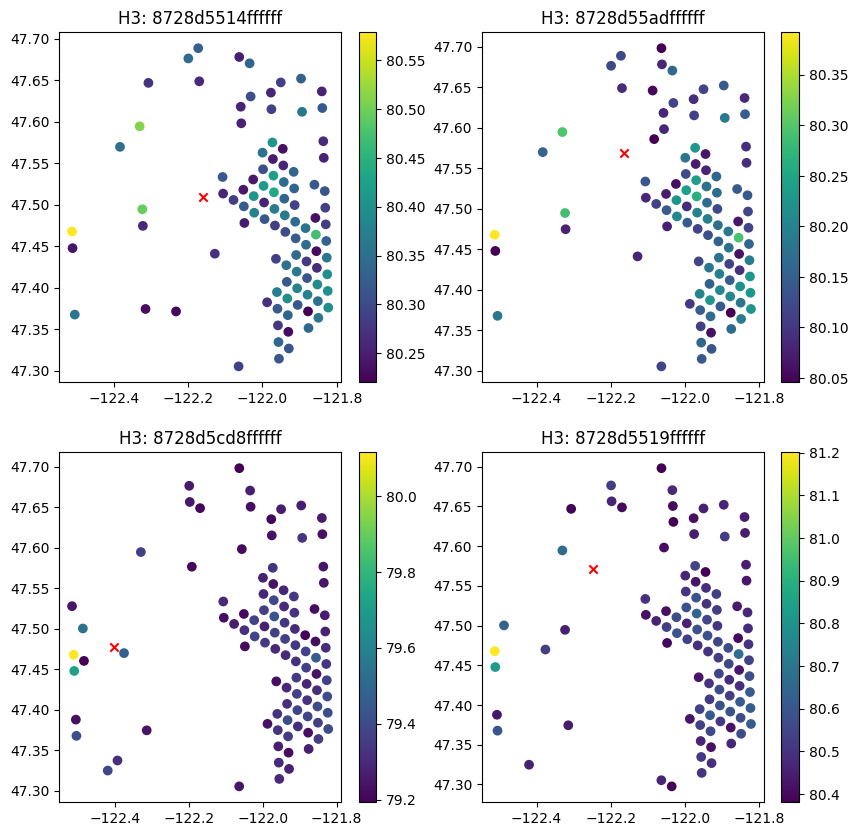

In [46]:
import random
h3s = random.shuffle(list(h3s_processed))

fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.flatten()

for i, id in  enumerate(list(h3s_processed)[0:4]):
    id_int = int("0x"+id, 0)
    id_recovered = hex(id_int)[2:]

    search_lat, search_lon = h3.h3_to_geo(id)

    result = qdrant_client.recommend(
        collection_name="vectorgeo",
        positive=[id_int],
        limit=100,
    )

    plt.sca(axes[i])
    plt.scatter([search_lon], [search_lat], c='r', marker='x')
    lats   = [scored_point.payload['location']['lat'] for scored_point in result]
    lons   = [scored_point.payload['location']['lon'] for scored_point in result]
    scores = [scored_point.score for scored_point in result]

    plt.scatter(lons, lats, c=scores)
    plt.colorbar()
    plt.title("H3: {}".format(id_recovered))

In [53]:
qdrant_client.recommend?

Signature:
qdrant_client.recommend(
    collection_name: str,
    positive: Sequence[Union[int, str, points_pb2.PointId]],
    negative: Optional[Sequence[Union[int, str, points_pb2.PointId]]] = None,
    query_filter: Union[qdrant_client.http.models.models.Filter, points_pb2.Filter, NoneType] = None,
    search_params: Union[qdrant_client.http.models.models.SearchParams, points_pb2.SearchParams, NoneType] = None,
    limit: int = 10,
    offset: int = 0,
    with_payload: Union[bool, List[str], qdrant_client.http.models.models.PayloadSelectorInclude, qdrant_client.http.models.models.PayloadSelectorExclude, points_pb2.WithPayloadSelector] = True,
    with_vectors: Union[bool, List[str]] = False,
    score_threshold: Optional[float] = None,
    using: Optional[str] = None,
    lookup_from: Union[qdrant_client.http.models.models.LookupLocation, points_pb2.LookupLocation, NoneType] = None,
    consistency: Union[qdrant_client.http.models.models.ReadConsistencyType, Annotated[int, Strict(s